<a href="https://colab.research.google.com/github/sattwiksuman/autonomous_driving/blob/main/Traffic_Signs_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###About the Dataset
Dataset has 43 classes of different traffic signs
Access a repository on bitbucket containing typical german traffic signs

In [1]:
#clone the repository:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
ls german-traffic-signs/

signnames.csv  test.p  train.p  valid.p


###Contents of german-traffic-signs

signnames.csv : spreadsheet containing traffic signs and labelled names mapping ClassId to SignName

Rest are pickle files = serialised data that can be unpickled/deserialised when desired

In [3]:
#Import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random

from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.models import Model

import pickle

In [4]:
# Set random seed in order to reproduce results

np.random.seed(0)

In [5]:
#Data initialization

#Load pickles data

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)     #dictionary of training data
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f) 
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f) 


In [6]:
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [7]:
#extracting freatures and labels and storing as respective x and y variables
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


So we have a total of around 35000 images divided into train, validation and test sets and they are all three channel images.

In [9]:
assert x_train.shape[0]==y_train.shape[0], 'The number of images is not equal to number of labels'
assert x_val.shape[0]==y_val.shape[0], 'The number of images is not equal to number of labels'
assert x_test.shape[0]==y_test.shape[0], 'The number of images is not equal to number of labels'

assert x_train.shape[1:]==(32, 32, 3), 'The image size is not 32x32x3'
assert x_val.shape[1:]==(32, 32, 3), 'The image size is not 32x32x3'
assert x_test.shape[1:]==(32, 32, 3), 'The image size is not 32x32x3'


In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [11]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


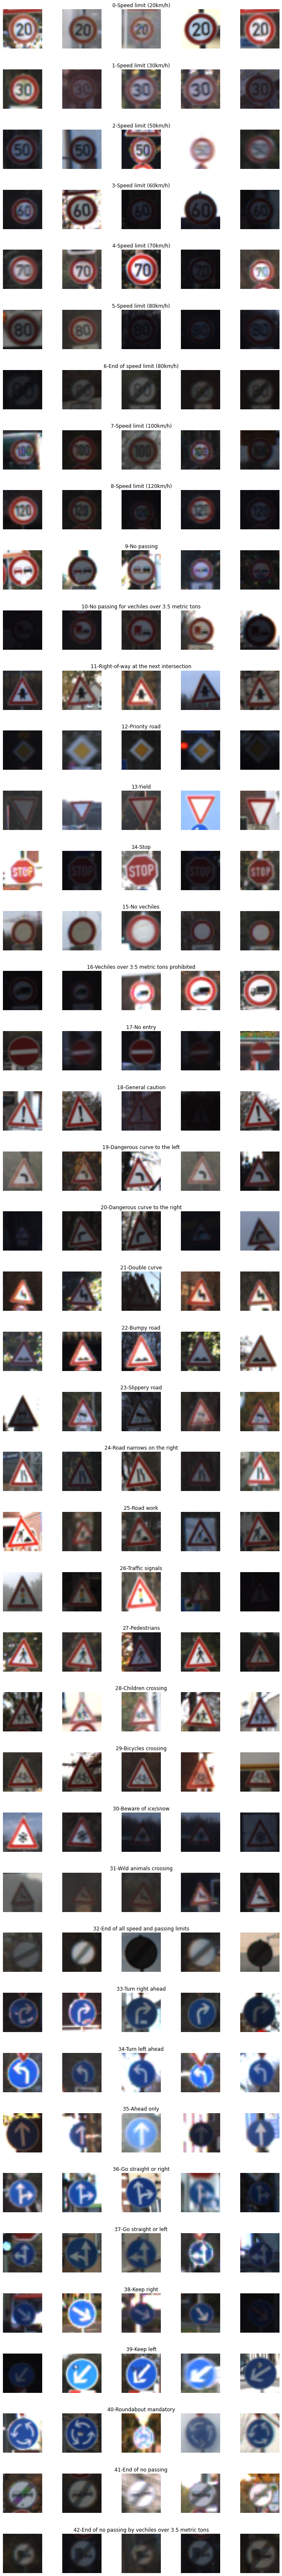

In [18]:
#Plot the data

num_of_samples=[]
 
cols = 5
num_classes = len(data)

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(cols*2, num_classes*2))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():       #iterate over dataframe as (index, series) pairs
      x_selected = x_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + '-' + row['SignName'])
        num_of_samples.append(len(x_selected))
print(num_of_samples)



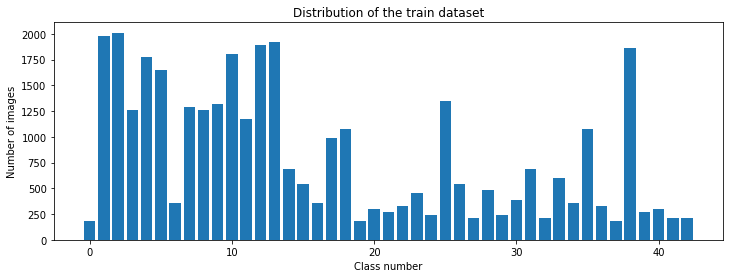

In [13]:
 plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

plt.show()

(32, 32, 3)
36


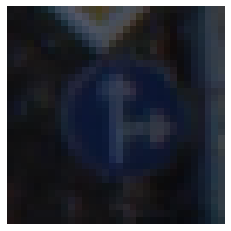

In [14]:
#preprocessing the images

import cv2

plt.imshow(x_train[1000])
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])

As per the signnames.csv, label 36 corresponds to go straight or go right. so thats correct

(32, 32)


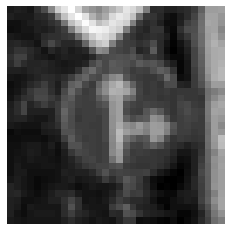

In [17]:
#cpnvert image to grayscale

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(x_train[1000])
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

(32, 32)


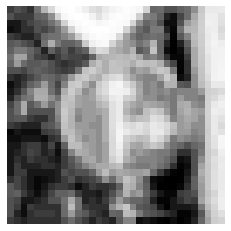

In [20]:
#histogram equialisation: equalises lighting in all images
#Also results in higher contrast as intensities are distributed across the pixels. 
#The histogram is intensities is flattened as gray values are distributed to brighter pixels.

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

In [22]:
#preprocess all images:

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocessing, x_train)))   #moves through an array and for each element returns a value accoring to some function executed on that element